# Identify the impact of an event in a particular area  


> 👋 Before moving on with this demo, you must first sign-up and request your Geosys APIs credentials here :
> - ⚙️[Try it now](https://earthdailyagro.com/geosys-registration/)

> For more information about our Geosys APIs : 
> - 📚 [Geosys APIs to connect with your digital ag application](https://app.geosys.com/#/documentation)


> **Demo Project:** This demo demonstrates the ability to identify and calculate the impacted area within a given geometric region resulting from a specific event.



### @author: Geosys





 ## Importing required libraries and create ImpactedAreasIdentificator instance

In [1]:
import sys
sys.path.append('../src/')
from geosyspy import Geosys
from dateutil.relativedelta import relativedelta
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from geosyspy.utils.constants import *
from vegetation_index_impacted_areas_identificator.impacted_areas_identification import *
from vegetation_index_impacted_areas_identificator.vegetation_index import *

import logging
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import datetime as dt


logger = logging.getLogger()
logger.setLevel(logging.ERROR)

client = ImpactedAreasIdentificator(Env.PROD)

 ## Input data

These input parameters are utilized in the demo to identify and calculate the impacted area resulting from the specified event and threshold within the given geometric region. The input data for this example consists of the following parameters:

#### geometry: 
A geometry string in WKT format representing the geometric region of interest. This geometry defines the boundaries of the area under analysis.

#### event_date: 
A datetime object representing the date of the event. In this case, the event date is "2022-09-15".

#### min_duration: 
An int-point value representing the minimum number between the dates to perform the impacted area analysis. In this example, the minimum duration is set to 10.

#### threshold: 
A floating-point value representing the threshold for evaluating the impact. In this example, the threshold is set to -0.15.

#### indicator: 
A vegetation index. In this example, the indicator is set to VegetationIndex.NDVI.


In [2]:
geometry = "POLYGON((-93.96113724989586 44.473577981244325,-93.95521493239097 44.474925388980246,-93.95049424452476 44.473057383559784,-93.94929261488609 44.4702093257966,-93.94903512282066 44.46641169924883,-93.95272584242515 44.46604417388972,-93.96010728163414 44.46616668259985,-93.96233887953453 44.46849429924204,-93.96113724989586 44.473577981244325))"

event_date = dt.datetime.strptime("2022-09-15", "%Y-%m-%d")

min_duration = 10

threshold = -0.15

indicator = VegetationIndex.NDVI


 # Option 1: Identify the impacted areas using Map Reference

## 1️⃣ Call the coverage for the area and retrieve images before and after the event date

To obtain coverage information for the area of interest, make a call to retrieve satellite images captured before and after the event date.

In [3]:
coverage_info_df, images_references = client.get_image_coverage_info_based_on_map_reference(geometry, event_date)

image_date_list = pd.to_datetime(coverage_info_df['image.date']).dt.date

## 2️⃣Retrieve vegetation index images before and after the specified event date 

Retrieve the Vegetation Index images captured before and after the specified event date


In [4]:
nearest_event_date = client.find_nearest_dates(event_date.date(), min_duration, image_date_list)

vi_images_nearest_event_date = client.get_vi_image_time_series(geometry,
                                                                         nearest_event_date["before_event_date"],
                                                                         nearest_event_date["after_event_date"],
                                                                   indicator.value)

vi_before_event_date = vi_images_nearest_event_date.sel(time=str(nearest_event_date["before_event_date"]))[indicator.value]

vi_after_event_date = vi_images_nearest_event_date.sel(time=str(nearest_event_date["after_event_date"]))[indicator.value]

2022-09-11 2022-09-21
The highest resolution's image grid size is (107, 101)


## 3️⃣Retrieve the impacted area based on a threshold

Calculate and retrieve the impacted area based on a specified threshold value.


### Retrieve the impacted area (xarray)


In [5]:
vi_impacted_area = client.calculate_and_filter_vi_difference_by_threshold(vi_before_event_date,
                                                                                  vi_after_event_date,
                                                                                  threshold)
vi_impacted_area

<xarray.DataArray 'ndvi' (y: 101, x: 107)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y                        (y) float64 44.48 44.47 44.47 ... 44.47 44.47 44.47
  * x                        (x) float64 -93.96 -93.96 -93.96 ... -93.95 -93.95
    image.sensor             <U10 'SENTINEL_2'
    image.soilMaterial       <U10 'VEGETATION'
    image.spatialResolution  float64 10.0
    image.weather            <U3 'DRY'
    crs                      <U9 'EPSG:4326'
    geometry_size_px         int32 8235

### Retrieve the impacted area (area and %)

In [6]:
impacted_area,impacted_area_percentage = client.calculate_impacted_area(geometry, vi_impacted_area)

print('# Impacted area: {:12.3f} m²'.format(impacted_area))
print('# Impacted area percentage: {:2.2f} %'.format(impacted_area_percentage))

# Impacted area:   390862.518 m²
# Impacted area percentage: 46.33 %


##  4️⃣ Display the results
Visualize the results using matplotlib by displaying the vegetation index of the image just before the event date, the image after the event date, and the impacted area.

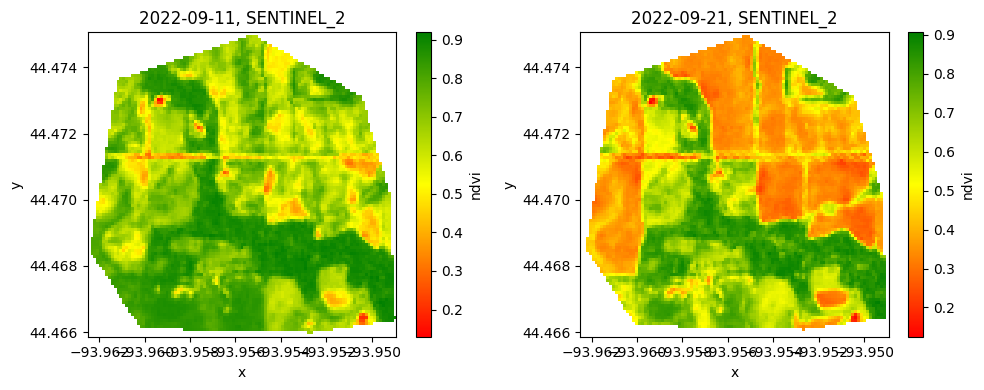

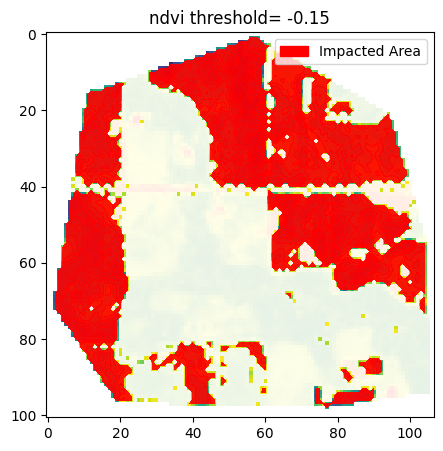

In [7]:
# Select only x and y dimension to display indicator vegetation index 
vi_before_event_date_image= vi_before_event_date.squeeze().drop(['time', 'band'])
vi_after_event_date_image= vi_after_event_date.squeeze().drop(['time', 'band'])

fig, ax = plt.subplots(1, 2, figsize=(10,4))
colors =['red', 'yellow', 'green']
cmap =  LinearSegmentedColormap.from_list(['red_green'],colors)
vi_before_event_date_image.plot(ax=ax[0], cmap = cmap)
ax[0].set_title(f"{np.datetime_as_string(vi_before_event_date['time'].values, unit='D')}, {vi_before_event_date['image.sensor'].values}")

vi_after_event_date_image.plot(ax=ax[1],  cmap = cmap)
ax[1].set_title(f"{np.datetime_as_string(vi_after_event_date['time'].values, unit='D')}, {vi_after_event_date['image.sensor'].values}")

fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=(5,5))
plt.imshow(vi_after_event_date_image,  cmap = cmap, alpha = 0.1)
plt.imshow(vi_impacted_area, aspect = 'auto')
plt.title(f"{indicator.value} threshold= {threshold}")
plt.contourf(vi_impacted_area, colors = 'red', alpha = 0.9)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color = 'red')], labels=['Impacted Area'])



 
 # Option 2: Identify the impacted areas using STAC Data

## 1️⃣ Defining variables for Sentinel-2 STAC to be used by Skyfox 

In [8]:
s2_sensor_collection = "sentinel-2-l2a"
s2_acm_mask = "sentinel-2-l2a-cog-ag-cloud-mask"
s2_bands= ["red", "green", "blue", "nir"]
mask_band = ["agriculture-cloud-mask"]

## 2️⃣ Retrieving Raw Image Data Cube using STAC Catalog
The retrieved images include data from 6 months before and after the event date.

In [9]:
raw_image_datacube = client.get_raw_images_from_stac(sensor_collection = s2_sensor_collection, 
                                                 event_date=event_date,
                                                 geometry_wkt= geometry,
                                                 bands =s2_bands)


## 3️⃣ Retrieving Cloud Mask Data Cube using STAC Catalog
The retrieved cloud mask correspond the images raw data in a period of 6 months before and after the event date.

In [10]:
cloudmask_datacube = client.get_cloud_mask_from_stac(s2_acm_mask, event_date, geometry, mask_band,
                                                           config=None)


## 4️⃣ Applying Cloud Mask to Raw Image Data Cube
 Applies the cloud mask to the raw image data cube.

In [11]:
free_cloud_images = client.apply_cloud_mask_to_raw_images_datacube(raw_image_datacube, cloudmask_datacube)

## 5️⃣ Retrieve vegetation index images before and after the specified event date 

In [ ]:
# Set the maximum cloud cover percentage
max_cloud_cover_percentage = 10

times_to_keep = client.get_nearest_event_date_time_indices(free_cloud_images, event_date, min_duration, max_cloud_cover_percentage)

vi_before_event_date, vi_after_event_date = client.calculate_vi_images_nearest_event_date(
            free_cloud_images, times_to_keep, indicator)


## 6️⃣ Retrieve the impacted area based on a threshold
Calculate and retrieve the impacted area based on a specified threshold value.

### Retrieve the impacted area (xarray)

In [ ]:
vi_impacted_area = client.calculate_and_filter_vi_difference_by_threshold(vi_before_event_date,
                                                                                vi_after_event_date, threshold)
vi_impacted_area

### Retrieve the impacted area (surface and %)

In [ ]:
impacted_area, impacted_area_percentage = client.calculate_impacted_area(geometry, vi_impacted_area.compute())

print('# Impacted area: {:12.3f} m²'.format(impacted_area))
print('# Impacted area percentage: {:2.2f} %'.format(impacted_area_percentage))

##  7️⃣ Display the results
Visualize the results using matplotlib by displaying the vegetation index of the image just before and after the event date as well as the impacted area.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
colors =['red', 'yellow', 'green']
cmap =  LinearSegmentedColormap.from_list(['red_green'],colors)
vi_before_event_date.plot(ax=ax[0], cmap = cmap)
ax[0].set_title(f"{np.datetime_as_string(vi_before_event_date['time'].values, unit='D')}")

vi_after_event_date.plot(ax=ax[1],  cmap = cmap)
ax[1].set_title(f"{np.datetime_as_string(vi_after_event_date['time'].values, unit='D')}")

fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=(5,5))
plt.imshow(vi_after_event_date.where(~np.isnan(vi_before_event_date)),  cmap = cmap, alpha = 0.1)
plt.imshow(vi_impacted_area, aspect = 'auto')
plt.title(f" {indicator.value} threshold= {threshold}")
plt.contourf(vi_impacted_area, colors = 'red', alpha = 0.9)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color = 'red')], labels=['Impacted Area'])